# importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Loading the data

In [2]:
# Load the CSV data
train_file_path = 'train.csv'
test_file_path = 'test.csv'

In [3]:
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Exploratory Data Analysis

In [4]:
train_data.head()

,ID,date,Item Id,Item Name,ad_spend,anarix_id,units,unit_price
0,2022-04-12_B09KDTS4DC,2022-04-12,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",NaN,NAPQUEEN,0.0,0.0
1,2022-04-12_B09MR2MLZH,2022-04-12,B09MR2MLZH,NapQueen 12 Inch Bamboo Charcoal Queen Size Me...,NaN,NAPQUEEN,0.0,0.0
2,2022-04-12_B09KSYL73R,2022-04-12,B09KSYL73R,"NapQueen Elsa 8"" Innerspring Mattress, Twin XL",NaN,NAPQUEEN,0.0,0.0
3,2022-04-12_B09KT5HMNY,2022-04-12,B09KT5HMNY,"NapQueen Elsa 6"" Innerspring Mattress, Twin",NaN,NAPQUEEN,0.0,0.0
4,2022-04-12_B09KTF8ZDQ,2022-04-12,B09KTF8ZDQ,"NapQueen Elsa 6"" Innerspring Mattress, Twin XL",NaN,NAPQUEEN,0.0,0.0


In [5]:
train_data.columns

Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id', 'units',
       'unit_price'],
      dtype='object')

In [6]:
test_data.columns

Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id',
       'unit_price'],
      dtype='object')

In [7]:
train_data.describe()

,ad_spend,units,unit_price
count,77303.000000,83592.000000,101490.000000
mean,110.771470,10.284381,106.750922
std,529.303777,68.945915,425.704733
min,0.000000,-173.000000,-8232.000000
25%,0.000000,0.000000,0.000000
50%,4.230000,1.000000,0.000000
75%,44.310000,5.000000,0.000000
max,47934.990000,9004.000000,21557.390000


In [8]:
train_data.shape

(101490, 8)

# Check null values

In [9]:
train_data.isnull().sum()

ID                0
date              0
Item Id           2
Item Name      1832
ad_spend      24187
anarix_id         0
units         17898
unit_price        0
dtype: int64

In [10]:
test_data.isnull().sum()

ID               0
date             0
Item Id          0
Item Name      344
ad_spend      1451
anarix_id        0
unit_price       0
dtype: int64

# Handling the null values and missing values

In [11]:
def handle_missing_values(data, is_train=True):
    data['Item Id'].fillna('Unknown', inplace=True)
    data['Item Name'].fillna('Unknown Item', inplace=True)
    data['ad_spend'].replace([np.inf, -np.inf], np.nan, inplace=True)
    data['ad_spend'].fillna(0, inplace=True)
    if is_train and 'units' in data.columns:
        data['units'].fillna(0, inplace=True)
    return data

In [12]:
train_data = handle_missing_values(train_data, is_train=True)
#test_data = handle_missing_values(test_data, is_train=False)

In [13]:
train_data['units'] = train_data['units'].apply(lambda x: max(x, 0))
train_data['unit_price'] = train_data['unit_price'].apply(lambda x: max(x, 0))

In [14]:
train_data.isnull().sum()

ID            0
date          0
Item Id       0
Item Name     0
ad_spend      0
anarix_id     0
units         0
unit_price    0
dtype: int64

In [15]:
train_data.head()

,ID,date,Item Id,Item Name,ad_spend,anarix_id,units,unit_price
0,2022-04-12_B09KDTS4DC,2022-04-12,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",0.0,NAPQUEEN,0.0,0.0
1,2022-04-12_B09MR2MLZH,2022-04-12,B09MR2MLZH,NapQueen 12 Inch Bamboo Charcoal Queen Size Me...,0.0,NAPQUEEN,0.0,0.0
2,2022-04-12_B09KSYL73R,2022-04-12,B09KSYL73R,"NapQueen Elsa 8"" Innerspring Mattress, Twin XL",0.0,NAPQUEEN,0.0,0.0
3,2022-04-12_B09KT5HMNY,2022-04-12,B09KT5HMNY,"NapQueen Elsa 6"" Innerspring Mattress, Twin",0.0,NAPQUEEN,0.0,0.0
4,2022-04-12_B09KTF8ZDQ,2022-04-12,B09KTF8ZDQ,"NapQueen Elsa 6"" Innerspring Mattress, Twin XL",0.0,NAPQUEEN,0.0,0.0


In [16]:
test_data.head()

,ID,date,Item Id,Item Name,ad_spend,anarix_id,unit_price
0,2024-07-01_B09KDR64LT,2024-07-01,B09KDR64LT,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
1,2024-07-01_B09KDTS4DC,2024-07-01,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",NaN,NAPQUEEN,0.0
2,2024-07-01_B09KDTHJ6V,2024-07-01,B09KDTHJ6V,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
3,2024-07-01_B09KDQ2BWY,2024-07-01,B09KDQ2BWY,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
4,2024-07-01_B09KDYY3SB,2024-07-01,B09KDYY3SB,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",101.72,NAPQUEEN,1094.5


# Date and Time column

In [17]:
# Create time-based features
def create_time_features(data):
    data['date'] = pd.to_datetime(data['date'])
    data['day_of_week'] = data['date'].dt.dayofweek
    data['month'] = data['date'].dt.month
    data['quarter'] = data['date'].dt.quarter
    return data

In [18]:
train_data = create_time_features(train_data)
test_data = create_time_features(test_data)

In [19]:
test_data.head()

,ID,date,Item Id,Item Name,ad_spend,anarix_id,unit_price,day_of_week,month,quarter
0,2024-07-01_B09KDR64LT,2024-07-01,B09KDR64LT,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0,0,7,3
1,2024-07-01_B09KDTS4DC,2024-07-01,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",NaN,NAPQUEEN,0.0,0,7,3
2,2024-07-01_B09KDTHJ6V,2024-07-01,B09KDTHJ6V,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0,0,7,3
3,2024-07-01_B09KDQ2BWY,2024-07-01,B09KDQ2BWY,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0,0,7,3
4,2024-07-01_B09KDYY3SB,2024-07-01,B09KDYY3SB,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",101.72,NAPQUEEN,1094.5,0,7,3


In [20]:
train_data['date'].head()

0   2022-04-12
1   2022-04-12
2   2022-04-12
3   2022-04-12
4   2022-04-12
Name: date, dtype: datetime64[ns]

# Aggregate the data by item-id and date

In [21]:
# Aggregate data by Item Id and date
def aggregate_data(data, is_train=True):
    agg_dict = {
        'ad_spend': 'sum',
        'unit_price': 'mean'
    }
    if is_train:
        agg_dict['units'] = 'sum'
    return data.groupby(['Item Id', 'date']).agg(agg_dict).reset_index()

In [22]:
train_aggregated = aggregate_data(train_data, is_train=True)
test_aggregated = aggregate_data(test_data, is_train=False)

In [23]:
test_aggregated.head()

,Item Id,date,ad_spend,unit_price
0,B09KDLQ2GW,2024-07-01,9.84,1145.0
1,B09KDLQ2GW,2024-07-02,9.24,229.0
2,B09KDLQ2GW,2024-07-03,5.10,687.0
3,B09KDLQ2GW,2024-07-04,11.04,1488.5
4,B09KDLQ2GW,2024-07-05,1.00,0.0


# Finding the unique ITEM-ID's

In [24]:
train_aggregated['Item Id'].value_counts()

B09MR2MLZH    781
B09MR3XT5G    781
B09KTF8ZDQ    781
B09KTJRHC7    781
B09KTMLQ1N    781
             ... 
B0CY5KFQBD     35
B0CY5LR4VX     21
B0CY5QQ49F     20
ASIN_BLANK      3
Unknown         2
Name: Item Id, Length: 218, dtype: int64

In [25]:
test_aggregated['Item Id'].value_counts()

B09KDLQ2GW    28
B09MR56Q9N    28
B09X1F8C23    28
B09X1HV1NL    28
B0B31VFJ6Q    28
              ..
B0BNL64PBG     2
B0BNL5LCM5     2
B0BNL1WL6R     2
B0BNL1RDVC     1
B0BNL424DV     1
Name: Item Id, Length: 155, dtype: int64

As we are dealing with Time Series Data the models like ARIMAX, SARIMAX, PROPHET, LSTM can be used. Here this was done using Prophet model

# Model Bulding - Prophet model

In [30]:
# Create a dictionary to hold DataFrames for each item
predictions = {}

# List of unique item IDs
item_ids = train_aggregated['Item Id'].unique()

for item_id in item_ids:
    train_item = train_aggregated[train_aggregated['Item Id'] == item_id].copy()
    test_item = test_aggregated[test_aggregated['Item Id'] == item_id].copy()
    
    if not train_item.empty and not test_item.empty:
        # Prepare data for Prophet
        train_item_prophet = train_item[['date', 'units']].rename(columns={'date': 'ds', 'units': 'y'})
        
        # Initialize and fit the Prophet model
        model_prophet = Prophet()
        model_prophet.fit(train_item_prophet)
        
        # Create future dataframe and predict
        future = model_prophet.make_future_dataframe(periods=len(test_item))
        forecast_prophet = model_prophet.predict(future)
        
        # Extract predictions for the test period
        forecast_prophet_test = forecast_prophet[-len(test_item):]
        predicted_prophet = forecast_prophet_test['yhat'].values
        
        # Add predictions to test_item DataFrame
        test_item['predicted_units_prophet'] = np.ceil(predicted_prophet).astype(int)
        
        # Remove negative values (if any) by setting them to zero
        test_item['predicted_units_prophet'] = test_item['predicted_units_prophet'].clip(lower=0)
        
        # Store the DataFrame in the dictionary
        predictions[item_id] = test_item[['date', 'Item Id', 'predicted_units_prophet']]

# Combine all predictions into a single DataFrame
combined_predictions = pd.concat(predictions.values(), ignore_index=True)


16:32:56 - cmdstanpy - INFO - Chain [1] start processing
16:32:56 - cmdstanpy - INFO - Chain [1] done processing
16:32:56 - cmdstanpy - INFO - Chain [1] start processing
16:32:57 - cmdstanpy - INFO - Chain [1] done processing
16:32:57 - cmdstanpy - INFO - Chain [1] start processing
16:32:57 - cmdstanpy - INFO - Chain [1] done processing
16:32:58 - cmdstanpy - INFO - Chain [1] start processing
16:32:58 - cmdstanpy - INFO - Chain [1] done processing
16:32:58 - cmdstanpy - INFO - Chain [1] start processing
16:32:59 - cmdstanpy - INFO - Chain [1] done processing
16:32:59 - cmdstanpy - INFO - Chain [1] start processing
16:32:59 - cmdstanpy - INFO - Chain [1] done processing
16:33:00 - cmdstanpy - INFO - Chain [1] start processing
16:33:00 - cmdstanpy - INFO - Chain [1] done processing
16:33:00 - cmdstanpy - INFO - Chain [1] start processing
16:33:01 - cmdstanpy - INFO - Chain [1] done processing
16:33:01 - cmdstanpy - INFO - Chain [1] start processing
16:33:01 - cmdstanpy - INFO - Chain [1]

In [42]:
combined_predictions
combined_predictions.rename(columns={'Item Id': 'ID'}, inplace=True)

combined_predictions.rename(columns={'predicted_units_prophet': 'TARGET'}, inplace=True)

# Saving results into csv file

In [43]:
# Save the aggregated DataFrame to a CSV file
combined_predictions.to_csv('task1_predictions.csv', index=False)
print('task1_results.csv')

task1_results.csv


As the test data and train data have different ID it is not valid to calculate the MSE. So choosing train_data and splitting to perform the model again and calculating the MSE

In [37]:
validation_data = train_data.copy()

predictions = {}
mse_results = []
item_ids = validation_data['Item Id'].unique()

for item_id in item_ids:
    # Filter validation data for the current item
    val_item = validation_data[validation_data['Item Id'] == item_id].copy()
    
    # Prepare data for Prophet
    train_item = train_aggregated[train_aggregated['Item Id'] == item_id].copy()
    if not train_item.empty and not val_item.empty:
        train_item_prophet = train_item[['date', 'units']].rename(columns={'date': 'ds', 'units': 'y'})
        
        # Initialize and fit the Prophet model
        model_prophet = Prophet()
        model_prophet.fit(train_item_prophet)
        
        # Create future dataframe and predict
        future = model_prophet.make_future_dataframe(periods=len(val_item))
        forecast_prophet = model_prophet.predict(future)
        
        # Extract predictions for the validation period
        forecast_prophet_val = forecast_prophet[-len(val_item):]
        predicted_prophet = forecast_prophet_val['yhat'].values
        
        # Add predictions to validation DataFrame
        val_item['predicted_units_prophet'] = np.ceil(predicted_prophet).astype(int)
        
        # Remove negative values (if any) by setting them to zero
        val_item['predicted_units_prophet'] = val_item['predicted_units_prophet'].clip(lower=0)
        
        # Store the DataFrame in the dictionary
        predictions[item_id] = val_item[['date', 'units', 'predicted_units_prophet', 'Item Id']]
        
        # Compute MSE for the current item
        mse = mean_squared_error(val_item['units'], val_item['predicted_units_prophet'])
        mse_results.append({'Item Id': item_id, 'MSE': mse})

16:42:15 - cmdstanpy - INFO - Chain [1] start processing
16:42:16 - cmdstanpy - INFO - Chain [1] done processing
16:42:16 - cmdstanpy - INFO - Chain [1] start processing
16:42:16 - cmdstanpy - INFO - Chain [1] done processing
16:42:17 - cmdstanpy - INFO - Chain [1] start processing
16:42:17 - cmdstanpy - INFO - Chain [1] done processing
16:42:18 - cmdstanpy - INFO - Chain [1] start processing
16:42:18 - cmdstanpy - INFO - Chain [1] done processing
16:42:19 - cmdstanpy - INFO - Chain [1] start processing
16:42:19 - cmdstanpy - INFO - Chain [1] done processing
16:42:20 - cmdstanpy - INFO - Chain [1] start processing
16:42:20 - cmdstanpy - INFO - Chain [1] done processing
16:42:21 - cmdstanpy - INFO - Chain [1] start processing
16:42:21 - cmdstanpy - INFO - Chain [1] done processing
16:42:21 - cmdstanpy - INFO - Chain [1] start processing
16:42:22 - cmdstanpy - INFO - Chain [1] done processing
16:42:22 - cmdstanpy - INFO - Chain [1] start processing
16:42:23 - cmdstanpy - INFO - Chain [1]

In [41]:
mse_results

[{'Item Id': 'B09KDTS4DC', 'MSE': 248.78974358974358},
 {'Item Id': 'B09MR2MLZH', 'MSE': 338.0845070422535},
 {'Item Id': 'B09KSYL73R', 'MSE': 1101.9660130718955},
 {'Item Id': 'B09KT5HMNY', 'MSE': 100999.49743589743},
 {'Item Id': 'B09KTF8ZDQ', 'MSE': 2330.2407170294496},
 {'Item Id': 'B09KTJRHC7', 'MSE': 9901.842509603073},
 {'Item Id': 'B09KTMKDKJ', 'MSE': 258584.38177014532},
 {'Item Id': 'B09KTMLQ1N', 'MSE': 7845.076824583867},
 {'Item Id': 'B09MR5WS3Y', 'MSE': 1.652116402116402},
 {'Item Id': 'B09KSXP3HN', 'MSE': 4347.491677336748},
 {'Item Id': 'B09MR3XT5G', 'MSE': 1525.417413572343},
 {'Item Id': 'B09MR3Y296', 'MSE': 34264.686299615874},
 {'Item Id': 'B09MR4B13C', 'MSE': 288068.09218950063},
 {'Item Id': 'B09MR4G722', 'MSE': 98.74775928297055},
 {'Item Id': 'B09MR4Z3H8', 'MSE': 440.4293059125964},
 {'Item Id': 'B09MR5Q6HJ', 'MSE': 110.42983751846381},
 {'Item Id': 'B09MR2FY5D', 'MSE': 970.3866837387964},
 {'Item Id': 'B09KDR64LT', 'MSE': 4.302666666666667},
 {'Item Id': 'B09KDN

# Plotting the graphs for an item-id

(array([19852., 19856., 19860., 19864., 19868., 19872., 19875.]),
 [Text(19852.0, 0, '2024-05-09'),
  Text(19856.0, 0, '2024-05-13'),
  Text(19860.0, 0, '2024-05-17'),
  Text(19864.0, 0, '2024-05-21'),
  Text(19868.0, 0, '2024-05-25'),
  Text(19872.0, 0, '2024-05-29'),
  Text(19875.0, 0, '2024-06-01')])

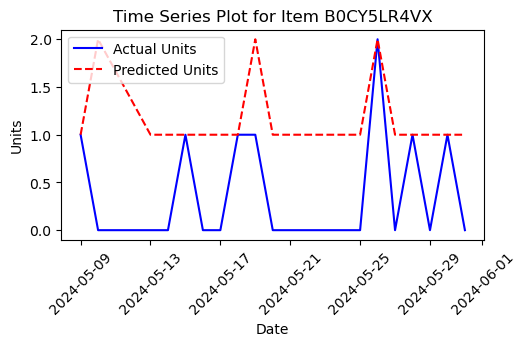

In [39]:
# Plotting
plt.figure(figsize=(12, 6))

# Time Series Plot
plt.subplot(2, 2, 1)
plt.plot(val_item['date'], val_item['units'], label='Actual Units', color='blue')
plt.plot(val_item['date'], val_item['predicted_units_prophet'], label='Predicted Units', color='red', linestyle='--')
plt.title(f'Time Series Plot for Item {item_id}')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.xticks(rotation=45)

(array([19851., 19858., 19865., 19875., 19882., 19889., 19896.]),
 [Text(19851.0, 0, '2024-05-08'),
  Text(19858.0, 0, '2024-05-15'),
  Text(19865.0, 0, '2024-05-22'),
  Text(19875.0, 0, '2024-06-01'),
  Text(19882.0, 0, '2024-06-08'),
  Text(19889.0, 0, '2024-06-15'),
  Text(19896.0, 0, '2024-06-22')])

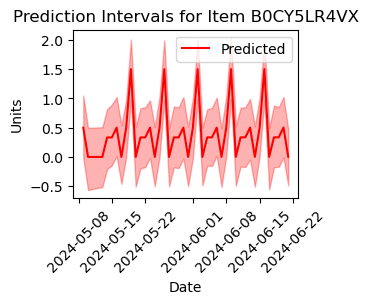

In [40]:
 # Prediction Interval Plot
plt.subplot(2, 2, 3)
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label='Predicted', color='red')
plt.fill_between(forecast_prophet['ds'], forecast_prophet['yhat_lower'], forecast_prophet['yhat_upper'], color='red', alpha=0.3)
plt.title(f'Prediction Intervals for Item {item_id}')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.xticks(rotation=45)